## Run the Self-Organizing Map
___

First, load the data

In [33]:
from astropy.io import fits
from astropy.table import Table

import numpy as np

In [34]:
#Load in data produced in primary_targeting_region.ipynb
cut_data_file = '/data2/lsajkov/mpdg/data_products/GAMA/GAMA_primtarg_snr100_lms6_12_25jun2024.fits'

with fits.open(cut_data_file) as cat:
    GAMA_vect_data = Table(cat[1].data)

GAMA_vect_data.add_column(GAMA_vect_data['r_mag_err'], index = 4, name = 'surf_bright_r_err')

In [35]:
#Select the needed data
input_data = GAMA_vect_data['r_mag', 'gr_color', 'surf_bright_r']
input_stds = GAMA_vect_data['r_mag_err', 'gr_color_err', 'surf_bright_r_err']

input_labels = GAMA_vect_data['log_stellar_mass', 'redshift']

tuple_labels = input_labels.as_array()
list_labels = [list(values) for values in tuple_labels]
input_labels = np.array(list_labels)

In [36]:
#Bin by redshift
redshift_thresh = 0.1
redshift_idx = input_labels[:, 1] < redshift_thresh

input_data = input_data[redshift_idx]
input_stds = input_stds[redshift_idx]
input_labels = input_labels[redshift_idx] 

___

Initialize the SOM

In [4]:
from mpdg_som import SelfOrganizingMap

In [38]:
#Set parameters
name = 'mass_profile_dwarf_galaxies' #name of the SOM

mapsize   = [28, 27] #size of the map. pass as a list of dimensions OR as an integer (also pass number of dimensions)
dimension = None

initialization         = 'pca' #random or pca (principal component analysis)
termination            = 'either' #when to stop learning. maximum_steps = stop when maximum_steps have elapsed. error_thresh = stop when the error is below this threshold. either = stop when either condition is fulfilled
learning_rate_function = 'power_law' #which learning rate function to use. currently implemented: power_law
neighborhood_function  = 'gaussian' #which neighborhood function to use. currently implemented: gaussian
error_estimator        = 'quantization_error' #which error estimation function to use. currently implemented: max_misalignment

learning_rate = 0.63 #used to adjust the learning rate function
kernel_spread = 8.06 #used to adjust the neighborhood function
maximum_steps = 14 #used to adjust the learning rate and neighborhood functions
error_thresh  = 0.1 #used to stop the SOM if termination = 'error thresh'

In [39]:
#Declare the SOM
SOM = SelfOrganizingMap(
    name                   = name,
    mapsize                = mapsize,
    dimension              = dimension,
    initialization         = initialization,
    termination            = termination,
    learning_rate_function = learning_rate_function,
    neighborhood_function  = neighborhood_function,
    error_estimator        = error_estimator,
    learning_rate          = learning_rate,
    kernel_spread          = kernel_spread,
    maximum_steps          = maximum_steps,
    error_thresh           = error_thresh
)

In [52]:
data_cut = 4800 * 2 #use up to this much of the data
randomized_idx = np.arange(0, len(input_data))
np.random.shuffle(randomized_idx)
randomized_idx = randomized_idx[:data_cut]

SOM.load_data(input_data[randomized_idx],
              variable_names = ['r_mag', 'gr_color', 'surf_bright_r'])
SOM.normalize_data()

SOM.load_standard_deviations(input_stds[randomized_idx])
SOM.normalize_standard_deviations()

SOM.data_statistics()

| Data statistics 
stat	r_mag	gr_color	surf_bright_r	
min	0.000	0.000	0.000	
max	1.000	1.000	1.000	
mean	0.772	0.691	0.562	
median	0.784	0.692	0.554	
std	0.091	0.143	0.118	

In [53]:
#Initialize the SOM
SOM.build_SOM()


| SOM. Step 0. Initialization: pca
Initial quantization error: 1.025


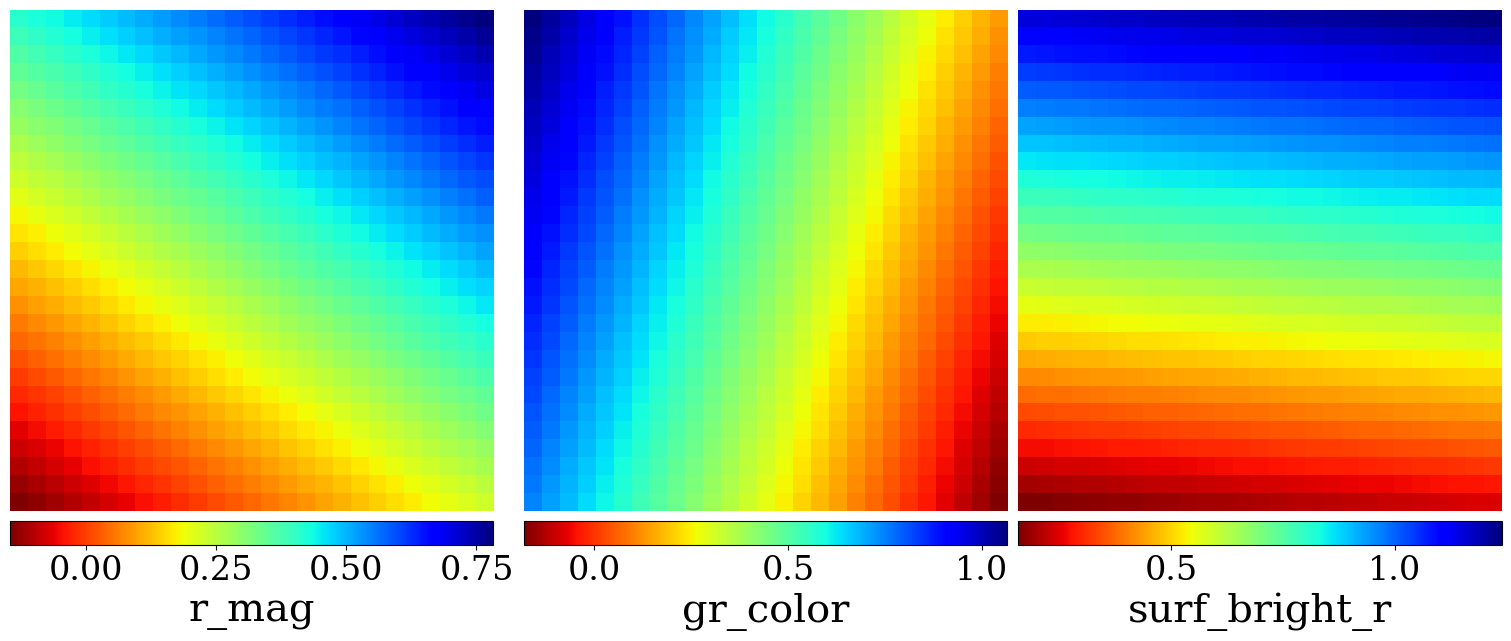

In [54]:
#Visualize SOM before training
SOM.show_map()

#Look at initial quantization error
from mpdg_som_utils import SOM_ErrorEstimators

initial_quant_error = SOM_ErrorEstimators.quantization_error(SOM.weights_map,
                                                             SOM.data,
                                                             SOM.bmu_indices)
print(f'I| Initial quantization error: {initial_quant_error:.3f}')

In [55]:
#Train the som
SOM.train()

Step 1 complete. Error: 0.161
Step 2 complete. Error: 0.170
Step 3 complete. Error: 0.186
Step 4 complete. Error: 0.190
Step 5 complete. Error: 0.137
Step 6 complete. Error: 0.133
Step 7 complete. Error: 0.125
Step 8 complete. Error: 0.138
Step 9 complete. Error: 0.118
Step 10 complete. Error: 0.113
Step 11 complete. Error: 0.103
Step 12 complete. Error: 0.108
Step 13 complete. Error: 0.099
SOM converged at step 13 to error 0.0986587405204773


0.09865874


| SOM. Step 13. Initialization: pca


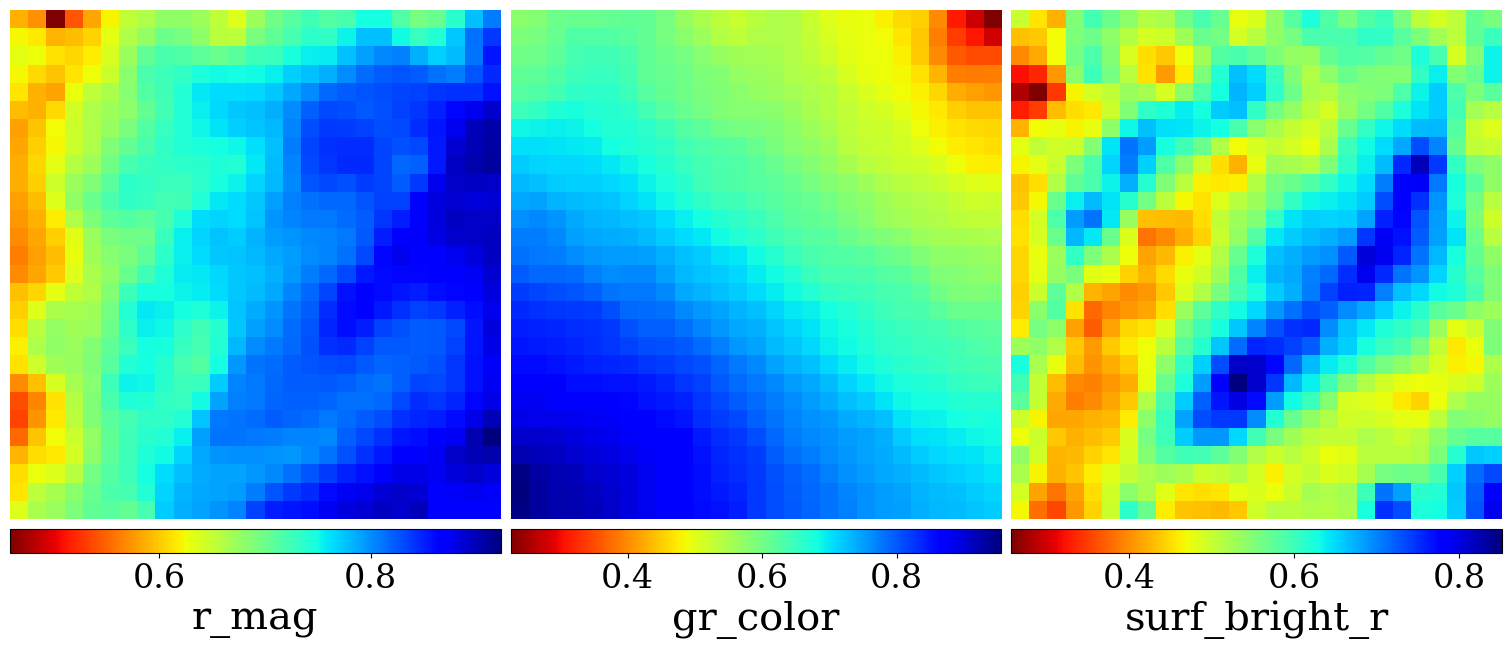

In [56]:
#Visualize the SOM after training
SOM.show_map()


| SOM. Step 13. Initialization: pca


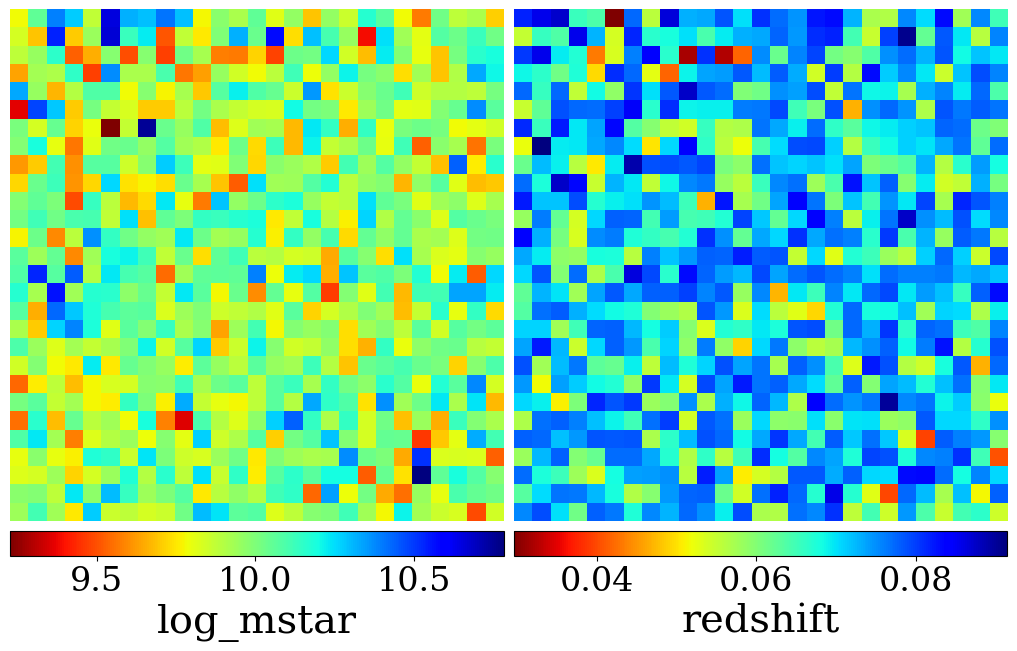

In [57]:
#Label the cells in the map with external parameters. Visualize the labeled map.
SOM.label_map(input_labels[:data_cut],
              parameter_names = ['log_mstar', 'redshift'])
SOM.show_map(show_labeled = True)

In [58]:
cell_histogram = np.full(np.product(SOM.mapsize), np.nan)
for i, cell in enumerate(np.unique(SOM.bmu_indices, axis = 0)):
    cell_histogram[i] = np.sum(np.all(SOM.bmu_indices == cell, axis = -1))

In [59]:
np.nanmedian(cell_histogram)

12.0

In [24]:
plt.bar(np.arange(0, len(cell_histogram)), cell_histogram)

NameError: name 'plt' is not defined

In [60]:
SOM.predict(SOM.data)

array([[10.21327686,  0.05605   ],
       [ 9.88569546,  0.082655  ],
       [ 9.83640957,  0.07539   ],
       ...,
       [10.08114433,  0.065215  ],
       [10.23994637,  0.06903499],
       [ 9.70675468,  0.07006   ]])

___

Compare predictions to inputs

In [124]:
import matplotlib.pyplot as plt

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_350924/553091456.py:15: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
/var/tmp/lsajkov/ipykernel_350924/553091456.py:16: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')
/var/tmp/lsajkov/ipykernel_350924/553091456.py:20: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


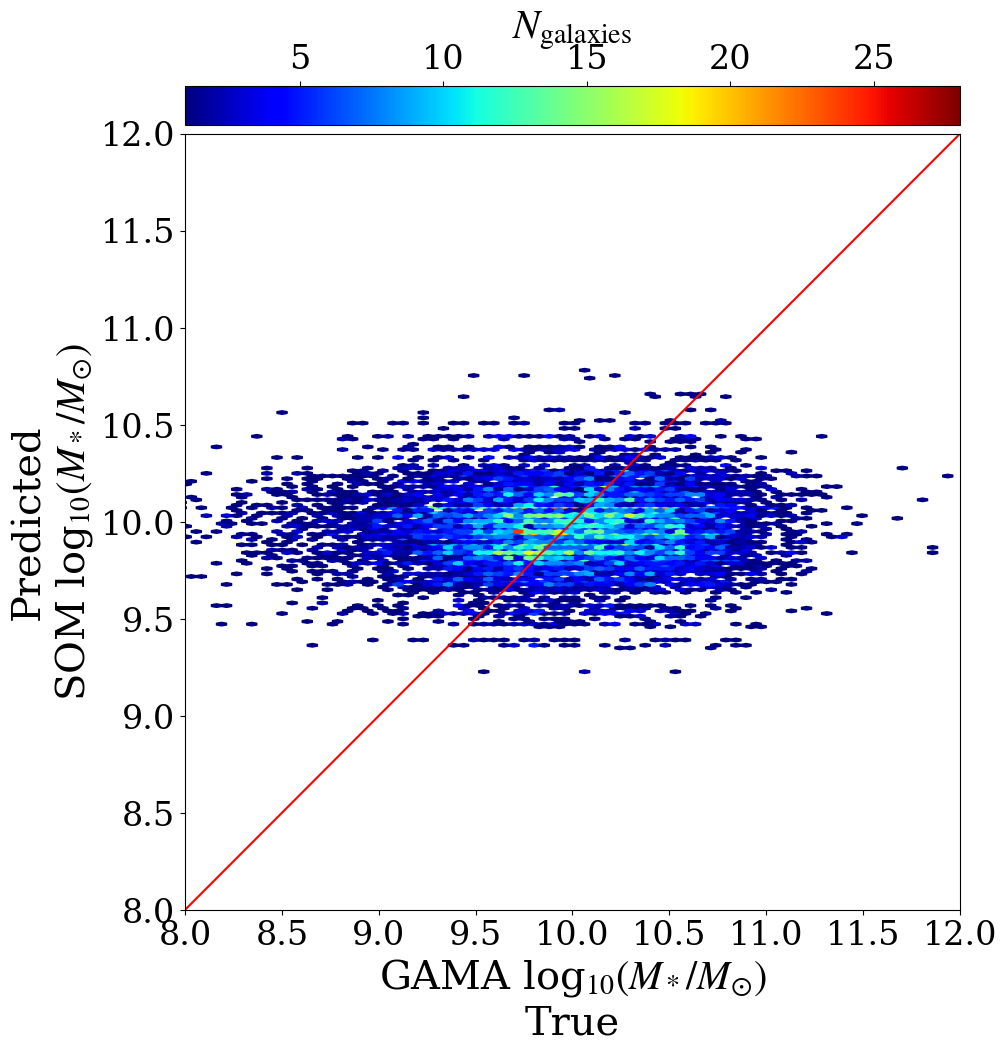

In [125]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.parameters[:, 0],
               SOM.prediction_results[:, 0],
               mincnt = 1, cmap = 'jet')

ax.axline([10, 10], slope = 1, color = 'red')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xticks(np.arange(8, 12.5, 0.5))

ax.set_xlabel('GAMA log$_{10} (M_*/M_{\odot})$\nTrue')
ax.set_ylabel('Predicted\nSOM log$_{10} (M_*/M_{\odot})$')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/tmp/lsajkov/ipykernel_350924/3434337412.py:19: SyntaxWarning: invalid escape sequence '\m'
  label = '$N_{\mathrm{galaxies}}$')


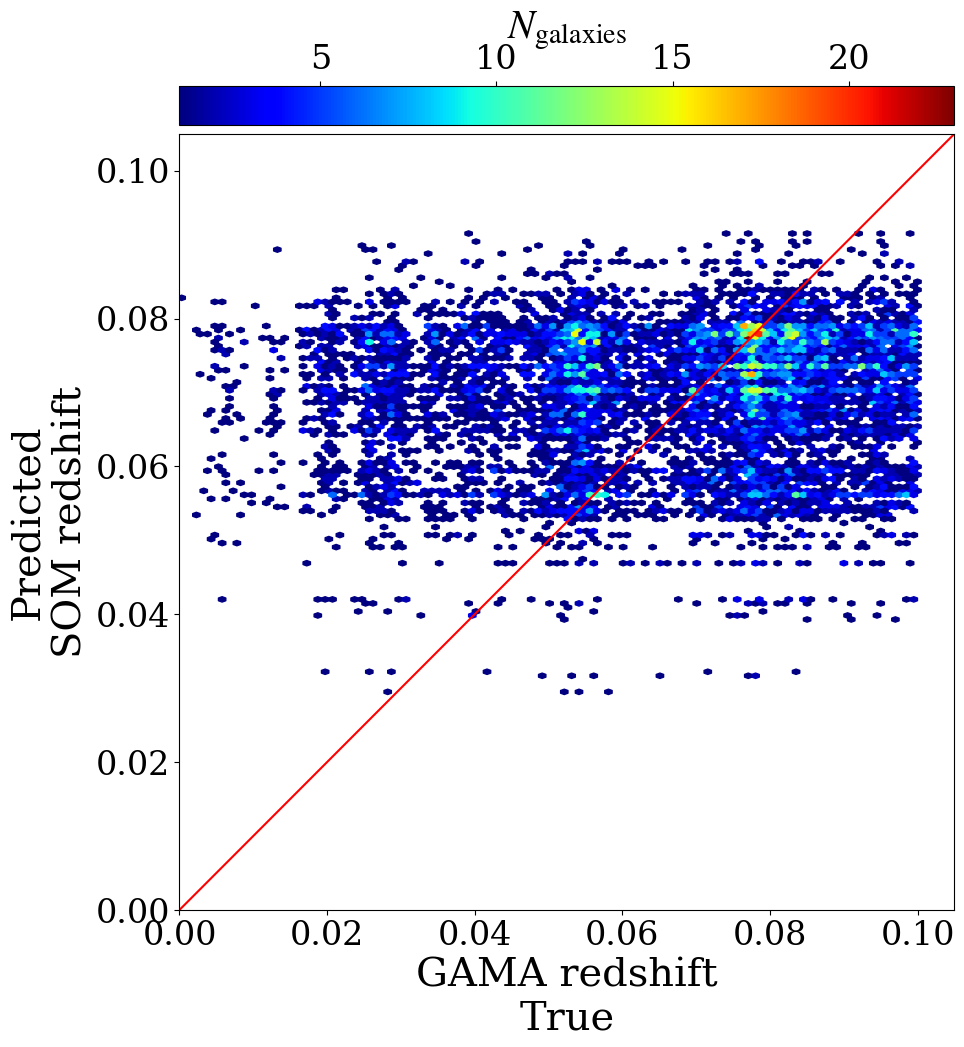

In [126]:
fig = plt.figure(figsize = (10, 12))

ax = fig.add_subplot()

hb = ax.hexbin(SOM.parameters[:, 1],
               SOM.prediction_results[:, 1],
               mincnt = 1, cmap = 'jet')

ax.axline([0, 0], slope = 1, color = 'red')

ax.set_xlim(0, .105)
ax.set_ylim(0, .105)

ax.set_xlabel('GAMA redshift\nTrue')
ax.set_ylabel('Predicted\nSOM redshift')

fig.colorbar(ax = ax, mappable = hb,
             location = 'top', pad = 0.01,
             label = '$N_{\mathrm{galaxies}}$')